# Task 1P - Chronic Kidney Disease prediction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import joblib
import zipfile

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the data set that has the details of the chronic kidney disease of 400 persons

In [ ]:
# Read lines from the file to a list
with open('/content/drive/MyDrive/T1/chronic_kidney_disease_full.arff', 'r') as file:
    lines = file.readlines()

# Extract all rows starting from line 145
lines_starting_from_145 = lines[145:]

# Apply corrections to each line
corrected_lines = []
for line in lines_starting_from_145:
    # Remove tabs and trailing newline, then strip leading and trailing spaces
    corrected_line = line.replace('\t', '').replace(',\n', '\n').strip()
    # Replace instances of double commas with single commas
    corrected_line = corrected_line.replace(',,', ',')
    corrected_line = ','.join([segment.strip() for segment in corrected_line.split(',')])
    # Add the corrected line to corrected_lines if it contains a comma
    if ',' in corrected_line:
        corrected_lines.append(corrected_line)

# Define column names
names = ['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba',
         'bgr', 'bu',  'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc',
         'rbcc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']

# Convert corrected lines to DataFrame
df = pd.DataFrame([line.split(',') for line in corrected_lines], columns=names)

# Replace "?" with NaN
df.replace('?', np.nan, inplace=True)

df.reset_index(drop=True, inplace=True)
df.insert(0, 'id', range(len(df)))

The dataset is of an arff file format. However there were few data issues that had ot hanlded to read the data content successfully and load it as a data frame object.
- extra tabs had to removed
- trailing spaced had to be stripped
- a row with addtional ',' had to be handled

Encoding: Ensure the nominal features are properly encoded.

In [ ]:
# Define mappings for nominal columns
nominal_mappings = {
    'pc': {'normal': 0, 'abnormal': 1},
    'pcc': {'notpresent': 0, 'present': 1},
    'ba': {'notpresent': 0, 'present': 1},
    'htn': {'no': 0, 'yes': 1},
    'dm': {'no': 0, 'yes': 1},
    'cad': {'no': 0, 'yes': 1},
    'appet': {'poor': 0, 'good': 1},
    'pe': {'no': 0, 'yes': 1},
    'ane': {'no': 0, 'yes': 1},
    'class': {'notckd': 0, 'ckd': 1}
}

# Map nominal columns
for column, mapping in nominal_mappings.items():
    df[column] = df[column].map(mapping)

# Convert 'age', 'bp', and 'sg' to float
df['age'] = df['age'].astype(float)
df['bp'] = df['bp'].astype(float)
df['sg'] = df['sg'].astype(float)

# Replace NaN values in 'al' and 'su' with -1
df['al'].fillna(-1, inplace=True)
df['su'].fillna(-1, inplace=True)

# Convert 'al' and 'su' to integers
df['al'] = df['al'].astype(int)
df['su'] = df['su'].astype(int)

# Convert object columns to numeric
object_columns = ['age','bp','sg','bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
for col in object_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

Perform EDA to check the distribution of values in numeric columns

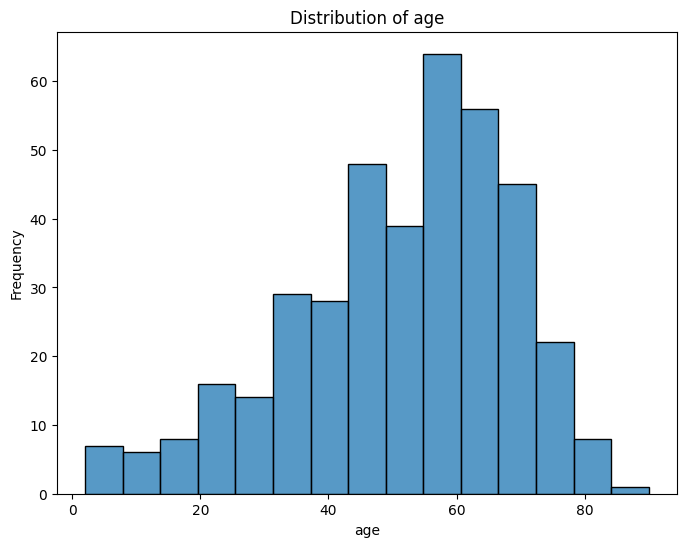

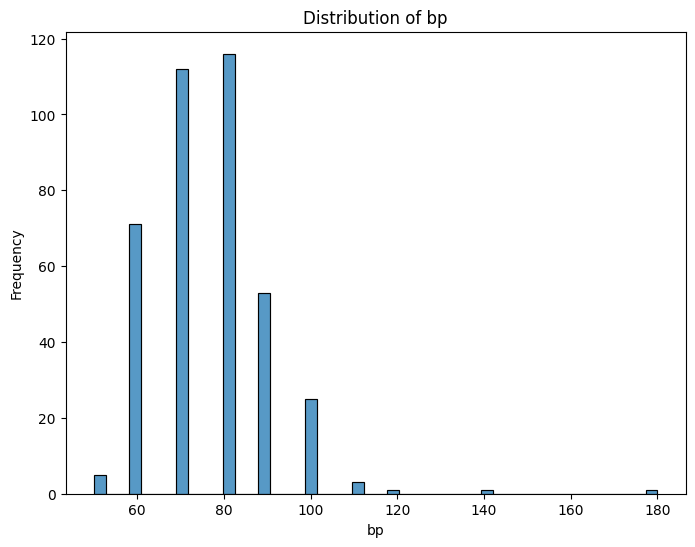

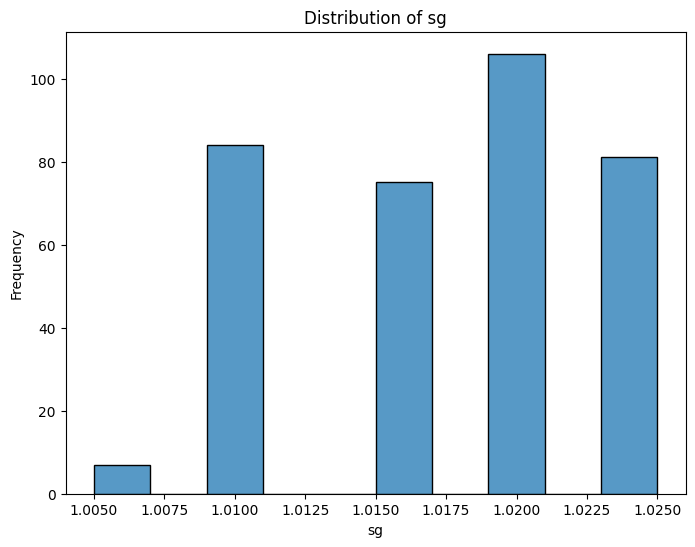

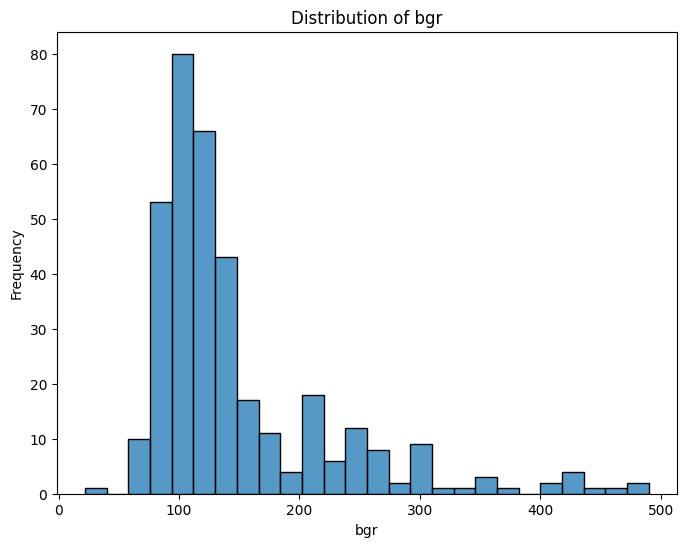

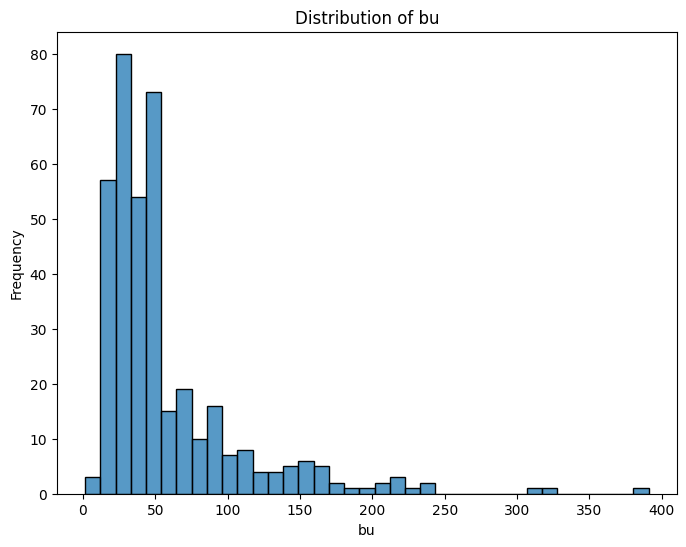

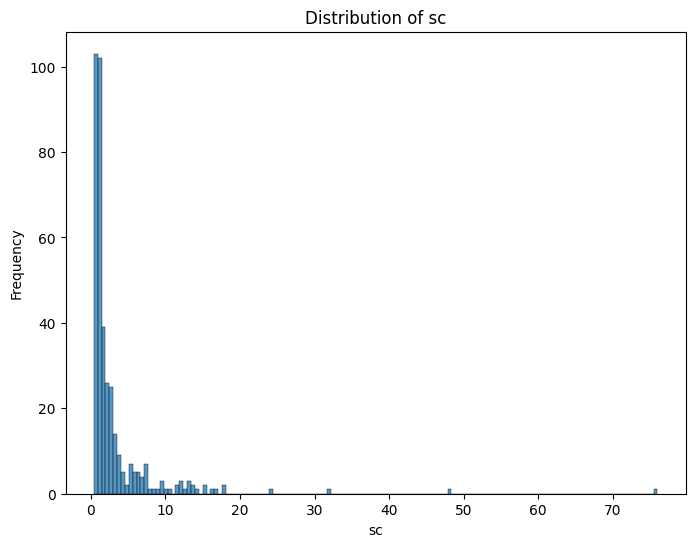

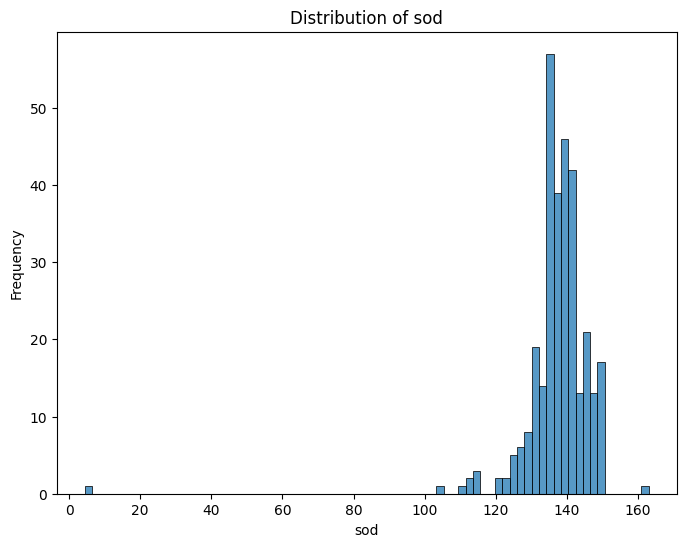

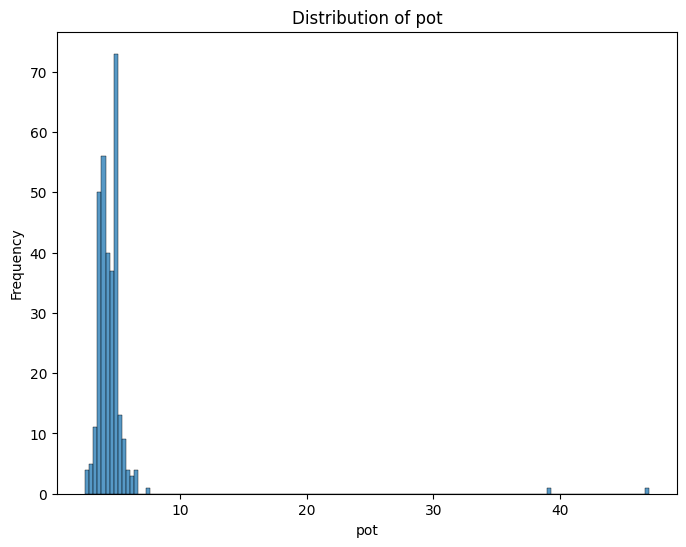

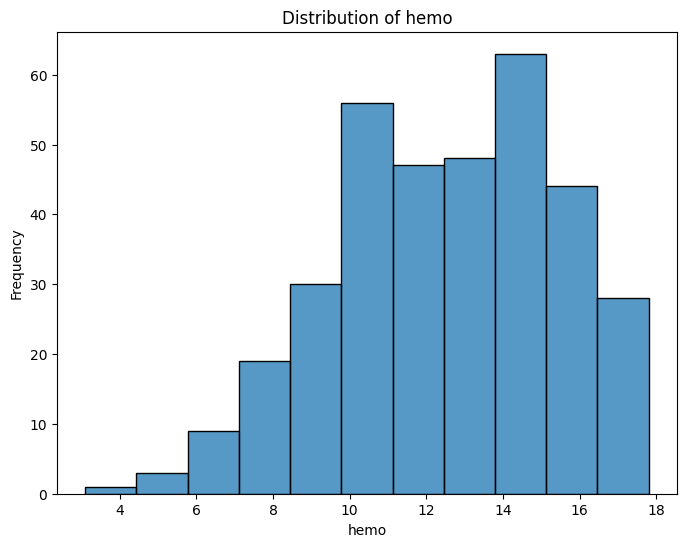

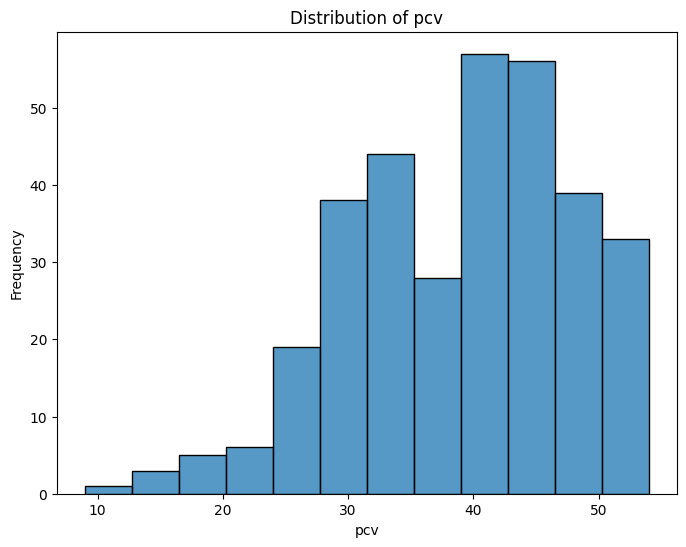

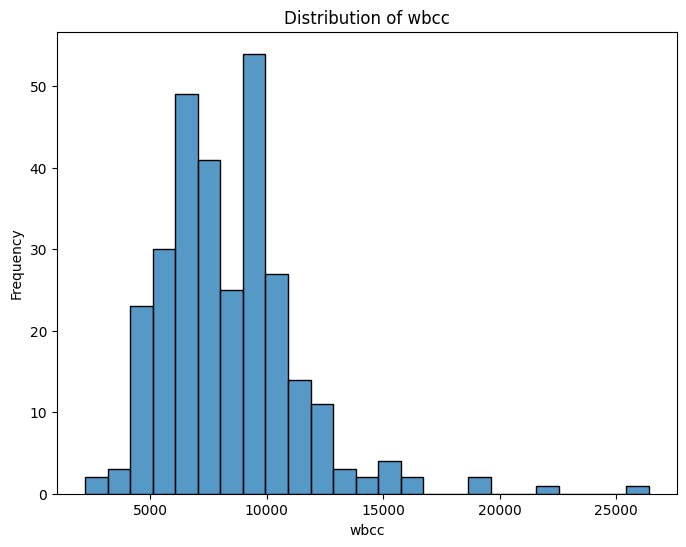

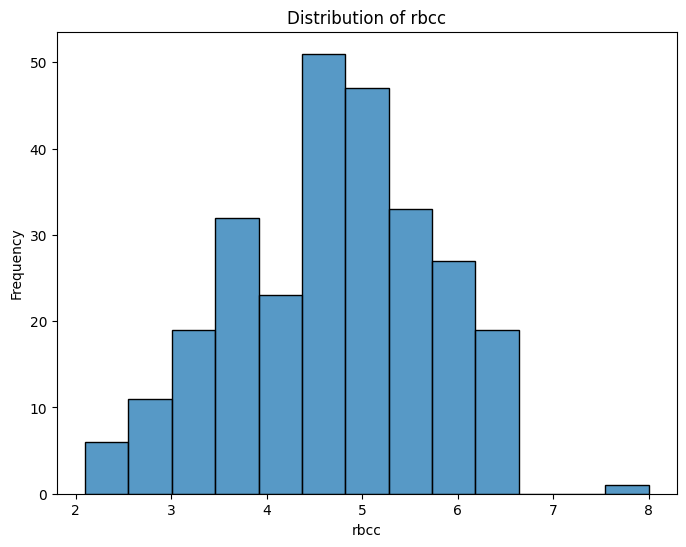

normal      201
abnormal     47
Name: rbc, dtype: int64


In [ ]:
# Visualize distribution of numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

numeric_columns = [col for col in df.select_dtypes(include=['float64']).columns if col not in nominal_mappings]
for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col].dropna())
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Check frequency of values in categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(df[col].value_counts())

Check the percentage of NaN values in the each column.

In [ ]:
# Calculate the percentage of NaN values in each column
nan_percentages = (df.isnull().sum() / len(df)) * 100

# Print the percentage of NaN values in each column
print("Percentage of NaN values in each column:")
print(nan_percentages)

Percentage of NaN values in each column:
id        0.00
age       2.25
bp        3.00
sg       11.75
al        0.00
su        0.00
rbc      38.00
pc       16.25
pcc       1.00
ba        1.00
bgr      11.00
bu        4.75
sc        4.25
sod      21.75
pot      22.00
hemo     13.00
pcv      17.75
wbcc     26.50
rbcc     32.75
htn       0.50
dm        0.50
cad       0.50
appet     0.25
pe        0.25
ane       0.25
class     0.00
dtype: float64


In [ ]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,400.0,NaN,NaN,NaN,199.5,115.614301,0.0,99.75,199.5,299.25,399.0
age,391.0,NaN,NaN,NaN,51.483376,17.169714,2.0,42.0,55.0,64.5,90.0
bp,388.0,NaN,NaN,NaN,76.469072,13.683637,50.0,70.0,80.0,80.0,180.0
sg,353.0,NaN,NaN,NaN,1.017408,0.005717,1.005,1.01,1.02,1.02,1.025
al,400.0,NaN,NaN,NaN,0.785,1.426135,-1.0,0.0,0.0,2.0,5.0
su,400.0,NaN,NaN,NaN,0.2725,1.134222,-1.0,0.0,0.0,0.0,5.0
rbc,248,2,normal,201,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pc,335.0,NaN,NaN,NaN,0.226866,0.419431,0.0,0.0,0.0,0.0,1.0
pcc,396.0,NaN,NaN,NaN,0.106061,0.308305,0.0,0.0,0.0,0.0,1.0
ba,396.0,NaN,NaN,NaN,0.055556,0.229351,0.0,0.0,0.0,0.0,1.0


<ipython-input-27-20bb54895c92>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


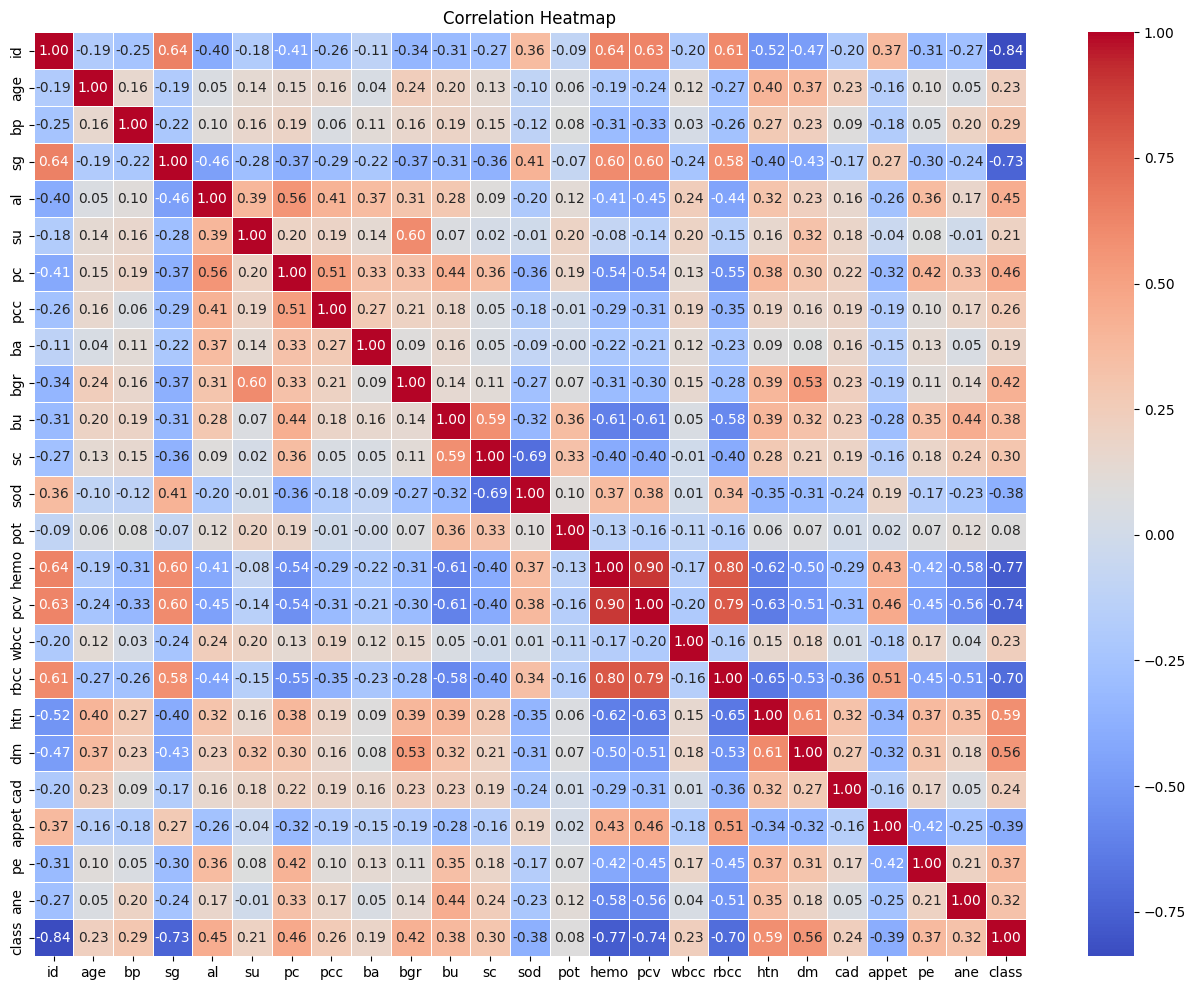

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

From the above EDA, we observe that the following attributes have a high % (more than 20%) of NaN values

rbc, sod, pot, wbcc and rbcc

Here, rbc attribute to hold nominal values might be a redundant data as we also have rbc count. Also the NaN % for rbc is very hight. The correlation map also not much correlation between rbc any another attribute. Therefore it would be better to drop the rbc attribute and have only the rbcc.

Data Imputation for empty values.

- For numerical features where there is null values for considerably more % (>=20)of records, we will impute them with median value of the respective class value of the row
- For numerical features where there is null values for considerably less % of (<20)records, we will impute them with median value of the feature
- For nominal feature, we inpute them with most fequent value

In [ ]:
# Drop the 'rbc' column
df.drop(columns=['rbc'], inplace=True)

# Drop the 'id' column
df.drop(columns=['id'], inplace=True)

# Fill NaN values based on overall median for certain columns
median_imputer = SimpleImputer(strategy='median')
for col in ['age', 'bp', 'sg', 'bgr', 'bu', 'sc', 'hemo', 'pcv']:
    df[col] = median_imputer.fit_transform(df[[col]])

# Fill NaN values based on mode for categorical columns
mode_imputer = SimpleImputer(strategy='most_frequent')
for col in ['pcc', 'ba']:
    df[col] = mode_imputer.fit_transform(df[[col]])

# Fill NaN values based on median for each class
for col in ['rbcc', 'sod', 'pot', 'wbcc']:
    median_notckd = df[df['class'] == 0][col].median()
    median_ckd = df[df['class'] == 1][col].median()
    df.loc[df['class'] == 0, col] = df.loc[df['class'] == 0, col].fillna(median_notckd)
    df.loc[df['class'] == 1, col] = df.loc[df['class'] == 1, col].fillna(median_ckd)

# Find the most frequent value of 'pc'
mode_pc = df['pc'].mode()[0]
df['pc'] = df['pc'].fillna(mode_pc)

# List of columns to update
columns_to_update = ['htn', 'dm', 'cad', 'appet', 'pe', 'ane']

# Iterate over each column
for col in columns_to_update:
    # Find the most frequent value in the column
    most_frequent_value = df[col].mode()[0]

    # Update NaN values with the most frequent value
    df[col] = df[col].fillna(most_frequent_value)



Let's look at the class imbalance in the data set with the value distribution of target class feature

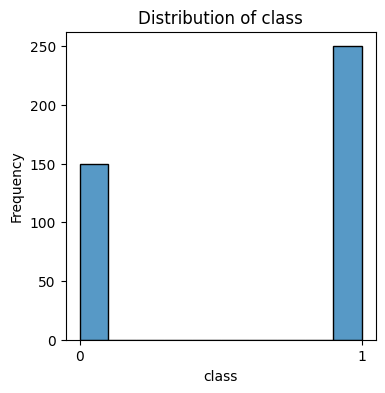

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

col = 'class'
plt.figure(figsize=(4, 4))
sns.histplot(df[col].dropna())
plt.title(f'Distribution of {col}')
plt.xlabel(col)
plt.ylabel('Frequency')

# Set x-axis ticks to be the unique values in the 'class' column
plt.xticks(df[col].unique())

plt.show()

In [ ]:
df["class"].value_counts()/df.shape[0]*100

1    62.5
0    37.5
Name: class, dtype: float64

We clearly see an imbalance in the data set with positive class being 62.5% and negative (notckd) being only 37.5%

Use resample method to upscale the minority class to have the same count as majority class so the data proportion is 50:50.

In [ ]:
# Upsample after NaN value imputation
# Separate majority and minority classes
majority_class = df[df['class'] == 1]
minority_class = df[df['class'] == 0]

# Upsample minority class
minority_upsampled = resample(minority_class,
                               replace=True,     # Sample with replacement
                               n_samples=len(majority_class),    # Match majority class size
                               random_state=42)  # Reproducible results

# Combine majority class with upsampled minority class
upsampled_df = pd.concat([majority_class, minority_upsampled])



In [ ]:
print(upsampled_df.shape)

(500, 24)


Now the data set has 250 rows for each class.

Split the upscaled dataset in train (80%) and test data (20%)

In [ ]:
# Splitting the data into train and test sets
X = upsampled_df.drop(columns=['class'])
y = upsampled_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




**Model training**: create two modes, one Decision Tree and another Random Forest. Run each with gridsearchCV algorithm to execute with a range of values for their respective hyper paramter values.

Fit the model with training data

In [ ]:
# Define parameter grids for Decision Tree and Random Forest
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, 24],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 3, 4]
}

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 20, 24],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 3, 4],
    'bootstrap': [True, False]
}

# Create pipeline for Decision Tree
dt_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', GridSearchCV(DecisionTreeClassifier(random_state=42), dt_param_grid, cv=5))
])

# Create pipeline for Random Forest
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5))
])

# Fit pipelines
dt_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)



Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('classifier',
                 GridSearchCV(cv=5,
                              estimator=RandomForestClassifier(random_state=42),
                              param_grid={'bootstrap': [True, False],
                                          'criterion': ['gini', 'entropy'],
                                          'max_depth': [5, 10, 20, 24],
                                          'min_samples_leaf': [2, 3, 4],
                                          'min_samples_split': [2, 5, 10],
                                          'n_estimators': [100, 200, 300]}))])

In [ ]:
# Get best models from pipelines
dt_best_model = dt_pipeline.named_steps['classifier'].best_estimator_
rf_best_model = rf_pipeline.named_steps['classifier'].best_estimator_



Get the best model and its hyperparameter for Decision Tree and Randon Forest

In [ ]:

# Print the best model and its hyperparameters for Decision Tree
print("Best Model and Hyperparameters for Decision Tree:")
print(dt_pipeline.named_steps['classifier'].best_estimator_)
print(dt_pipeline.named_steps['classifier'].best_params_)

# Print the best model and its hyperparameters for Random Forest
print("\nBest Model and Hyperparameters for Random Forest:")
print(rf_pipeline.named_steps['classifier'].best_estimator_)
print(rf_pipeline.named_steps['classifier'].best_params_)

Best Model and Hyperparameters for Decision Tree:
DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, random_state=42)
{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

Best Model and Hyperparameters for Random Forest:
RandomForestClassifier(max_depth=5, min_samples_leaf=2, random_state=42)
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


Best Parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2}

Best Parameters for Random Forest: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

The best parameters for both models indicate that the trees are not very deep and have minimal leaf samples and splits, which suggests that the models are not overfitting.

Predict the accuracy and generate the classification report the best models with the test data.

Compare the accuracy score of the best decision model vs the best random forest model and find which performs better.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(



Decision Tree Classifier:
Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       1.00      0.98      0.99        46

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion Matrix:
[[54  0]
 [ 1 45]]


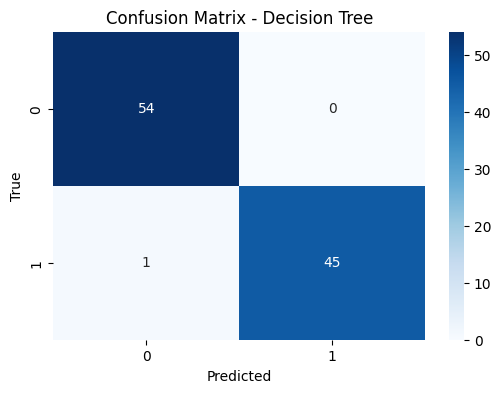

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



Random Forest Classifier:
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      1.00      1.00        46

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Confusion Matrix:
[[54  0]
 [ 0 46]]


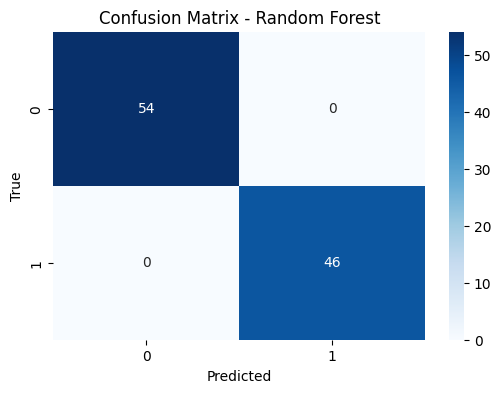

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Decision Tree performance
dt_best_predictions = dt_best_model.predict(X_test)
print("\nDecision Tree Classifier:")
print("Accuracy:", accuracy_score(y_test, dt_best_predictions))
print("Classification Report:")
print(classification_report(y_test, dt_best_predictions))
# Confusion Matrix for Decision Tree
dt_conf_matrix = confusion_matrix(y_test, dt_best_predictions)
print("Confusion Matrix:")
print(dt_conf_matrix)

# Plot Confusion Matrix for Decision Tree
plt.figure(figsize=(6, 4))
sns.heatmap(dt_conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - Decision Tree')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Random Forest performance
rf_best_predictions = rf_best_model.predict(X_test)
print("\nRandom Forest Classifier:")
print("Accuracy:", accuracy_score(y_test, rf_best_predictions))
print("Classification Report:")
print(classification_report(y_test, rf_best_predictions))
# Confusion Matrix for Random Forest
rf_conf_matrix = confusion_matrix(y_test, rf_best_predictions)
print("Confusion Matrix:")
print(rf_conf_matrix)

# Plot Confusion Matrix for Random Forest
plt.figure(figsize=(6, 4))
sns.heatmap(rf_conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Accuracy and Classification Reports:**

Both models achieve an accuracy of ~1.00, which is very high.
The precision, recall, and F1-score for both classes (0 and 1) are also very high, indicating good performance in predicting both classes.
The classification reports show high precision, recall, and F1-score for both classes, indicating that the models perform well in classifying both positive and negative instances.
Comparison:

Both models have identical accuracy, precision, recall, and F1-score values, indicating that they perform equally well on the given dataset.
The Decision Tree model has a simpler structure compared to the Random Forest model, as it is based on a single decision tree.
The Random Forest model uses an ensemble of decision trees, which may provide better generalization and robustness to outliers and noise in the data.

**Conclusion:**

Based on the provided observations, both models perform exceptionally well on the given dataset.
However, Decision Tree model has a simpler structure when compared to Random Forest model.
The robustness, generalization and the ensemble nature of Random Forest makes it the preferred mode.

Export the best model and zip the file

In [ ]:
# Save the best model
joblib.dump(best_model, '/content/drive/MyDrive/T1/best_model.pkl')

# Zip the best model
with zipfile.ZipFile('/content/drive/MyDrive/T1/best_model.zip', 'w') as zipf:
    zipf.write('/content/drive/MyDrive/T1/best_model.pkl')

**Summary of the result:**

In summary, the robustness, generalization, and ensemble nature of Random Forest models stem from their ability to harness the power of multiple decision trees, introduce randomness during training, and aggregate predictions to make more accurate and stable predictions on unseen data.

**Robustness**:

Random Forest models are robust due to their ensemble nature and the use of multiple decision trees. Here's how it contributes to robustness:

**Reduced Overfitting**: Each decision tree in the Random Forest is trained on a random subset of the data (bagging) and a random subset of features. This randomness helps to reduce overfitting by introducing diversity among the trees.

**Noise Reduction**: The aggregation of predictions from multiple trees helps to reduce the impact of noisy data or outliers on the overall model performance. Since Random Forest considers the average or majority vote of multiple trees, it is less susceptible to noise in the data.

**Stability**: Random Forest models tend to be more stable compared to individual decision trees. Minor fluctuations in the training data are less likely to significantly affect the overall model performance, making Random Forests robust to changes in the dataset.

**Generalization**:

Random Forest models generalize well to unseen data due to their ensemble nature and the way they incorporate randomness during training:

**Ensemble Averaging**: By aggregating predictions from multiple trees, Random Forest models capture a more robust representation of the underlying patterns in the data. This ensemble averaging helps to reduce variance and improve generalization to unseen data.

**Feature Randomness**: Random Forests introduce randomness by considering only a subset of features at each split of a decision tree. This prevents the model from becoming overly dependent on any single feature and promotes better generalization to new data.

**Cross-Validation**: Random Forest models often perform well during cross-validation, indicating that they can effectively generalize to unseen data. Cross-validation involves training the model on different subsets of the data and evaluating its performance on unseen data, providing a measure of the model's generalization ability.

**Ensemble Nature**:

Random Forest models are an ensemble learning technique that combines multiple individual decision trees to make predictions. Here's why this ensemble nature is beneficial:

**Reduction of Variance**: By averaging or aggregating predictions from multiple trees, Random Forests reduce the variance of the model compared to individual decision trees. This helps to make the model more stable and less sensitive to fluctuations in the data.

**Better Performance**: Ensemble methods often outperform individual models by leveraging the collective wisdom of multiple learners. Random Forests exploit the diversity among the constituent trees to achieve better predictive performance compared to standalone decision trees.

**Robustness to Overfitting**: The ensemble nature of Random Forests makes them less prone to overfitting compared to individual decision trees. The aggregation of predictions from multiple trees helps to smooth out the noise and biases present in the training data, leading to a more robust model.

